In [1]:
import pandas as pd
import folium
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gpd
import libpysal
from shapely.geometry import Point, Polygon
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
from contextily import add_basemap
import networkx as nx
import numpy as np
import logging
import requests_cache
import requests
import json

In [2]:
df = pd.read_csv(r"C:\Users\marco\Downloads\Electric_Vehicle_Charging_Stations_in_New_York.csv")

In [3]:
colonne_irrilevanti = ['Fuel Type Code', 'Intersection Directions', 'Station Phone', 'Status Code',
                       'Owner Type Code', 'Federal Agency ID', 'Federal Agency Name', 'Cards Accepted',
                       'EV Network Web', 'ZIP', 'Groups With Access Code', 'Expected Date', 'Access Days Time',
                       'Geocode Status', 'Updated At', 'Plus4', 'Date Last Confirmed', "EV Other Info", "Open Date"]

# Eliminazione delle colonne irrilevanti
df.drop(colonne_irrilevanti, axis=1, inplace=True)

In [4]:
df.head()

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types
0,ShopRite Plaza,2333 Nott St E,Niskayuna,NY,NaN,2.0,NaN,Non-Networked,42.816614,-73.889657,50854,J1772
1,GMC Copley Parking - Tesla,2000 Broadway,New York,NY,NaN,3.0,NaN,Tesla,40.775496,-73.981552,115044,TESLA
2,WHITE PLAINS EVSE1,1 Maple Ave,White Plains,NY,NaN,2.0,NaN,ChargePoint Network,41.028410,-73.759380,197206,J1772
3,3500 Dekalb Ave,3500 Dekalb Ave,Bronx,NY,NaN,2.0,NaN,FLO,40.882337,-73.880265,201636,J1772
4,134 N 4th St,134 N 4th St,Brooklyn,NY,NaN,4.0,NaN,FLO,40.716441,-73.960043,202931,J1772


In [6]:
città_rilevanti = ['New York',"Bronx","Brooklyn","Queens","Staten Island",
         "Manhattan","Borough Park","Washington Heights","New York City",
        "Astoria","Jamaica","JAMAICA","Jackson Heights",]
esclusione = ["Geneva on the Lake Resort", "ABELENORTHSIDE STATION 1","Buy Low Flooring / Queen of Harts Pizza"]
Network = ["Tesla","LIVINGSTON","EV Connect"]

In [7]:
# df = df.query("City not in @città_rilevanti")

In [8]:
occurrences = df['EV_Network'].value_counts()
print(occurrences)

ChargePoint Network    1525
Tesla                   562
Non-Networked           282
LIVINGSTON              237
EV Connect              236
Blink Network            86
FLO                      43
Electrify America        37
AMPUP                    29
Volta                    26
SHELL_RECHARGE           24
eVgo Network             22
SemaCharge Network       19
RIVIAN_WAYPOINTS          4
SWTCH                     3
OpConnect                 2
FLASH                     1
EVGATEWAY                 1
CHARGELAB                 1
Name: EV_Network, dtype: int64


In [9]:
# NYC_df = NYC_df.query("City not in @esclusione")

In [10]:
# df = df.query("EV_Network in @Network")

I 4 maggiori Network di ricarica appartengono a Tesla, Livingstone e EV Connect, e quelli che non sono compresi in nessun network specifico. Con questi 4 otteniamo circa il 42% della rete. 

Vengono eliminate le colonne che non presentano dati utili all'analisi o che presentano dei NaN in ogni osservazione.

In [11]:
df.index.names = ['Index']
df = df.fillna(value=0)
df.shape

(3140, 12)

Il dataset presenta 3140 osservazioni, solo relative allo stato di New York. 

In [14]:
df =df.reset_index(drop=True)

In [15]:
df

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types
0,ShopRite Plaza,2333 Nott St E,Niskayuna,NY,0.0,2.0,0.0,Non-Networked,42.816614,-73.889657,50854,J1772
1,GMC Copley Parking - Tesla,2000 Broadway,New York,NY,0.0,3.0,0.0,Tesla,40.775496,-73.981552,115044,TESLA
2,WHITE PLAINS EVSE1,1 Maple Ave,White Plains,NY,0.0,2.0,0.0,ChargePoint Network,41.028410,-73.759380,197206,J1772
3,3500 Dekalb Ave,3500 Dekalb Ave,Bronx,NY,0.0,2.0,0.0,FLO,40.882337,-73.880265,201636,J1772
4,134 N 4th St,134 N 4th St,Brooklyn,NY,0.0,4.0,0.0,FLO,40.716441,-73.960043,202931,J1772
...,...,...,...,...,...,...,...,...,...,...,...,...
3135,SPOT cowork Rochester - Tesla,21 Goodway Dr,Rochester,NY,0.0,4.0,0.0,Tesla,43.091974,-77.580604,154441,TESLA
3136,Veterans Memorial Park,185 Main St,Mount Morris,NY,0.0,4.0,0.0,EV Connect,42.718388,-77.869315,168430,J1772
3137,CHEEKTOWAGA ALEXANDER #4,275 Alexander Ave,Buffalo,NY,0.0,1.0,0.0,ChargePoint Network,42.913030,-78.791232,183769,J1772
3138,286WAE 286 WAS AVE EXT,286 Washington Ave Ext,Albany,NY,0.0,2.0,0.0,ChargePoint Network,42.705350,-73.860690,152461,J1772


In [16]:
# NYC_df["Next Latitude"],NYC_df["Next Longitude"] = "",""

In [17]:
# for i in range(0, (NYC_df.shape[0]-1)):
#          NYC_df["Next Latitude"][i] = NYC_df["Latitude"][i+1]
#          NYC_df["Next Longitude"][i] = NYC_df["Longitude"][i+1]

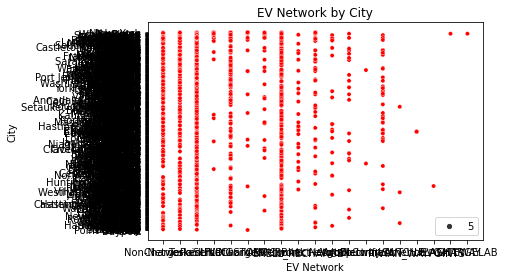

In [18]:
sns.scatterplot(x='EV_Network', y='City', data=df, size=5, color='red')
plt.title("EV Network by City")
plt.xlabel("EV Network")
plt.ylabel("City")
plt.show()

Plot della mappa

In [19]:
location = df[["Latitude", "Longitude", "Station Name","EV_Network","ID"]]

# Calculate the center of the map based on the mean of Latitude and Longitude values
mean_latitude = location['Latitude'].mean()
mean_longitude = location['Longitude'].mean()
map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=6, control_scale=True)

location.apply(lambda x: folium.Marker([x["Latitude"], x["Longitude"]], popup=x["EV_Network"]).add_to(map), axis=1)
map


Calcolo distanza e tempo di guida da una colonnina alla successiva

In [20]:
df["Distance"],df["Duration"]="",""

Calcolo della distanza tramite Open Street Map

In [21]:
API_key = '96dd7cb32a8d43a1b8c78d219b21d381'
url = 'http://router.project-osrm.org/route/v1/driving/'

In [22]:
def getDistances(row):
    o1 = str(row['Longitude']) +',' + str(row['Latitude'])
    o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
    x = o1 + ';' + o2
    
    response = requests.get(url+x)
    data = json.loads(response.content)
    
    if response.status_code == 200:
        return data['routes'][0]['distance']/1000 #in km
    else:
        return 0

In [23]:
def getDuration(row):
    o1 = str(row['Longitude']) +',' + str(row['Latitude'])
    o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
    x = o1 + ';' + o2
    
    response = requests.get(url+x)
    data = json.loads(response.content)
    
    if response.status_code == 200:
        return data['routes'][0]['duration']/60 #in min
    else:
        return 0

In questo modo abbiamo ottenuto la distanza (in miglia) tra una colonnina e la successiva

In [24]:
# # Network = ["Tesla","Non-Networked","LIVINGSTON","EV Connect"]
# tesla_df = df[df['EV_Network'] =="Tesla"]
# evc_df = df[df['EV_Network'] =="EV Connect"]
# l_df = df[df['EV_Network'] =="LIVINGSTON"]

In [25]:
df = df.sort_values(by=["City",'Latitude', 'Longitude'])
# evc_df = evc_df.sort_values(by=["City",'Latitude', 'Longitude'])
# l_df = l_df.sort_values(by=["City",'Latitude', 'Longitude'])

In [26]:
df["Next Latitude"] = df["Latitude"].shift(-1)
df["Next Longitude"] = df["Longitude"].shift(-1)

In [27]:
# evc_df["Next Latitude"] = evc_df["Latitude"].shift(-1)
# # evc_df["Next Longitude"] = evc_df["Longitude"].shift(-1)

In [28]:
# l_df["Next Latitude"] = l_df["Latitude"].shift(-1)
# l_df["Next Longitude"] = l_df["Longitude"].shift(-1)

Divido il dataset in 4 (uno per ogni network) in modo da poter confrontare i pattern di posizionamento.

In [29]:
df = df.reset_index(drop=True)
# evc_df =evc_df.reset_index(drop=True)
# l_df =l_df.reset_index(drop=True)

In [31]:
df["Distance"]  = df.apply(getDistances, axis = 1)
df["Duration"]  = df.apply(getDuration, axis = 1)
# evc_df["Distance"]  = evc_df.apply(getDistances, axis = 1)
# evc_df["Duration"]  = evc_df.apply(getDuration, axis = 1)
# l_df["Distance"]  = l_df.apply(getDistances, axis = 1)
# l_df["Duration"]  = l_df.apply(getDuration, axis = 1)

In [35]:
df

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Distance,Duration,Next Latitude,Next Longitude
0,AMCR CASINO 1.2,873 State Route 37,Akwesasne,NY,0.0,2.0,0.0,ChargePoint Network,44.971275,-74.643180,167256,J1772,0.0019,0.008333,44.971310,-74.643234
1,AMCR CASINO 1.1,873 State Route 37,Akwesasne,NY,0.0,2.0,0.0,ChargePoint Network,44.971310,-74.643234,181482,J1772,4.1165,6.648333,44.977945,-74.689688
2,Saint Regis Mohawk Health Services,404 NY-37,Akwesasne,NY,0.0,2.0,0.0,Non-Networked,44.977945,-74.689688,227679,J1772,370.3307,293.293333,42.626225,-73.758180
3,APDC ADMIN LOT PORT 1.1,106 Smith Blvd,Albany,NY,0.0,2.0,0.0,ChargePoint Network,42.626225,-73.758180,181004,J1772,0.0011,0.001667,42.626232,-73.758250
4,APDC ADMIN LOT PORT 1.2,106 Smith Blvd,Albany,NY,0.0,2.0,0.0,ChargePoint Network,42.626232,-73.758250,165222,J1772,0.0008,0.001667,42.626240,-73.758310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,Steet-Ponte Ford Lincoln Mazda,5074 Commercial Dr,Yorkville,NY,0.0,1.0,0.0,Non-Networked,43.110055,-75.293478,53976,J1772,1.1409,3.191667,43.113663,-75.285065
3136,IONIQ STATION2,5190 Commercial Dr,Yorkville,NY,0.0,1.0,0.0,ChargePoint Network,43.113663,-75.285065,204500,J1772,0.0000,0.000000,43.113758,-75.284960
3137,IONIQ STATION1,5190 Commercial Dr,Yorkville,NY,0.0,1.0,0.0,ChargePoint Network,43.113758,-75.284960,204501,J1772,338.6411,267.375000,41.038926,-73.867014
3138,Aqueduct Parking Lot,110 Main Street,irvington,NY,0.0,2.0,0.0,EV Connect,41.038926,-73.867014,168429,J1772,18.0589,19.320000,41.098418,-73.996593


In [42]:
quantiles = df["Distance"].quantile([0.25, 0.75])
media = df["Distance"].mean()
quantiles_d= df["Duration"].quantile([0.25, 0.75])
media_d = df["Duration"].mean()
print("\nDistance")
print("\nQuantili a 0.25 e 0.75:")
print(quantiles)
print(media)

print("\nDuration")
print("\nQuantili a 0.25 e 0.75:")
print(quantiles_d)
print(media_d)
# tesla_df = tesla_df.loc[tesla_df['Distance'] > 500]
# tesla_df = tesla_df.loc[tesla_df['Duration'] > 150]


Distance

Quantili a 0.25 e 0.75:
0.25    0.23925
0.75    5.99940
Name: Distance, dtype: float64
54.65317305732484

Duration

Quantili a 0.25 e 0.75:
0.25    0.792917
0.75    9.047083
Name: Duration, dtype: float64
44.77926592356688


In questo caso il Plot dei grafi divisi per ogni Network non avrebbe senso, si andrebbe a creare un Grafo estremamente complesso e pooco significante.

In [43]:
# df =df.reset_index(drop=True)
# evc_df =evc_df.reset_index(drop=True)
# l_df =l_df.reset_index(drop=True)

Tutti e 3 i grafi disegnati presetano dei tratti molto simili, quasi a voler indicare un pattern di poszionamento. 

In [50]:
def create_and_draw_graph(df, color, title):
    G = nx.Graph()
    for index, row in df.iterrows():
        G.add_node(row["ID"], pos=(row["Longitude"], row["Latitude"]))
        if index > 0:
            G.add_edge(df.iloc[index-1]["ID"], row["ID"])
    nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=False, node_size=10, node_color=color)
    plt.title(title)

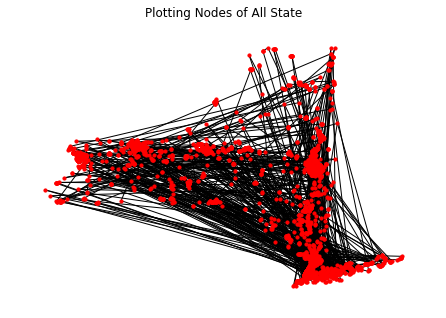

In [52]:
data = [(df, "red", "Plotting Nodes of All State"),]

for df, color, title in data:
    create_and_draw_graph(df, color, title)

plt.savefig("./graph_state_general.png", dpi=300)
plt.show()

In [90]:
lista = ['New York',"Bronx","Brooklyn","Queens","Staten Island",
         "Manhattan","Borough Park","Washington Heights","New York City",
        "Astoria","Jamaica","JAMAICA","Jackson Heights",]
esclusione = ["Geneva on the Lake Resort", "ABELENORTHSIDE STATION 1","Buy Low Flooring / Queen of Harts Pizza"]
NYC_df = df.query("City in @lista")
NYC_df = NYC_df.query("City not in @esclusione")
NYC_df.index.names = ['Index']
NYC_df = NYC_df.fillna(value=0)
NYC_df =NYC_df.reset_index(drop=True)

In [91]:
NYC_df.shape

(550, 16)

In [92]:
NYC_df["Next Latitude"],NYC_df["Next Longitude"] = "",""
NYC_df["Next Latitude"] = NYC_df["Latitude"].shift(-1)
NYC_df["Next Longitude"] = NYC_df["Longitude"].shift(-1)
NYC_df

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Distance,Duration,Next Latitude,Next Longitude
0,PV Parking 34-11 Steinway - Tesla,34-11 Steinway St,Astoria,NY,0.0,4.0,0.0,Tesla,40.755508,-73.922168,150584,TESLA,1.0261,1.710000,40.761412,-73.923755
1,31-99 33rd St,31-99 33rd St,Astoria,NY,0.0,2.0,0.0,FLO,40.761412,-73.923755,193926,J1772,1.4870,3.083333,40.762417,-73.926985
2,ProPark 29-10 Broadway - Tesla,29-10 Broadway,Astoria,NY,0.0,4.0,0.0,Tesla,40.762417,-73.926985,150616,TESLA,0.3038,0.696667,40.762763,-73.924473
3,Astoria Central Parking - Tesla,31-57 31st St,Astoria,NY,0.0,4.0,0.0,Tesla,40.762763,-73.924473,114881,TESLA,2.7713,5.443333,40.769436,-73.905312
4,Alps Provisions - Tesla,43-11 23rd Ave.,Astoria,NY,0.0,3.0,0.0,Tesla,40.769436,-73.905312,168571,TESLA,1.2604,2.120000,40.773632,-73.913315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,HAMPTON INN STATION 1,1120 South Ave,Staten Island,NY,0.0,2.0,0.0,ChargePoint Network,40.612696,-74.179012,168146,J1772,0.0055,0.023333,40.612706,-74.179076
546,HAMPTON INN STATION 5,1120 South Ave,Staten Island,NY,0.0,2.0,0.0,ChargePoint Network,40.612706,-74.179076,181664,J1772,7.0502,10.376667,40.629424,-74.111586
547,Bruno's Bakery and Restaurant - Tesla,676 Forest Ave,Staten Island,NY,0.0,2.0,0.0,Tesla,40.629424,-74.111586,150541,TESLA,5.2379,8.853333,40.644763,-74.075837
548,Empire Outlets Garage,35B Richmond Terrace,Staten Island,NY,0.0,5.0,0.0,Volta,40.644763,-74.075837,220701,J1772,171.9819,144.713333,40.847482,-73.937862


In [93]:
NYC_df["Distance"]  = NYC_df.apply(getDistances, axis = 1)
NYC_df["Duration"]  = NYC_df.apply(getDuration, axis = 1)

Impongo, per sicurezza, che la distanza e la durata di viaggio non siano superiori a 100km e 100 minuti per evitare outliers.

In [104]:
NYC_df = NYC_df.loc[NYC_df['Distance'] < 100]
NYC_df = NYC_df.loc[NYC_df['Duration'] < 100]
NYC_df = NYC_df.loc[NYC_df['Distance'] != 0]
NYC_df = NYC_df.loc[NYC_df['Duration'] != 0]
NYC_df =NYC_df.reset_index(drop=True)

In [105]:
NYC_df

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Distance,Duration,Next Latitude,Next Longitude
0,PV Parking 34-11 Steinway - Tesla,34-11 Steinway St,Astoria,NY,0.0,4.0,0.0,Tesla,40.755508,-73.922168,150584,TESLA,1.0261,1.710000,40.761412,-73.923755
1,31-99 33rd St,31-99 33rd St,Astoria,NY,0.0,2.0,0.0,FLO,40.761412,-73.923755,193926,J1772,1.4870,3.083333,40.762417,-73.926985
2,ProPark 29-10 Broadway - Tesla,29-10 Broadway,Astoria,NY,0.0,4.0,0.0,Tesla,40.762417,-73.926985,150616,TESLA,0.3038,0.696667,40.762763,-73.924473
3,Astoria Central Parking - Tesla,31-57 31st St,Astoria,NY,0.0,4.0,0.0,Tesla,40.762763,-73.924473,114881,TESLA,2.7713,5.443333,40.769436,-73.905312
4,Alps Provisions - Tesla,43-11 23rd Ave.,Astoria,NY,0.0,3.0,0.0,Tesla,40.769436,-73.905312,168571,TESLA,1.2604,2.120000,40.773632,-73.913315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,HAMPTON INN STATION 2,1120 South Ave,Staten Island,NY,0.0,2.0,0.0,ChargePoint Network,40.612688,-74.178948,181662,J1772,0.0055,0.021667,40.612696,-74.179012
508,HAMPTON INN STATION 1,1120 South Ave,Staten Island,NY,0.0,2.0,0.0,ChargePoint Network,40.612696,-74.179012,168146,J1772,0.0055,0.023333,40.612706,-74.179076
509,HAMPTON INN STATION 5,1120 South Ave,Staten Island,NY,0.0,2.0,0.0,ChargePoint Network,40.612706,-74.179076,181664,J1772,7.0502,10.376667,40.629424,-74.111586
510,Bruno's Bakery and Restaurant - Tesla,676 Forest Ave,Staten Island,NY,0.0,2.0,0.0,Tesla,40.629424,-74.111586,150541,TESLA,5.2379,8.853333,40.644763,-74.075837


In [106]:
quantiles = NYC_df["Distance"].quantile([0.25, 0.75])
media = NYC_df["Distance"].mean()
minimum = NYC_df["Distance"].min()
maximum = NYC_df["Distance"].max()


print("\nDistance")
print("\nQuantili a 0.25 e 0.75:")
print(quantiles)
print("Media :" + str(media))
print("Minimo :"+str(minimum))
print("Massimo :"+ str(maximum))


quantiles_d= NYC_df["Duration"].quantile([0.25, 0.75])
media_d = NYC_df["Duration"].mean()
print("\nDuration")
print("\nQuantili a 0.25 e 0.75:")
minimum_d = NYC_df["Duration"].min()
maximum_d = NYC_df["Duration"].max()
print(quantiles_d)
print("Media :" +str(media_d))
print("Minimo :"+str(minimum_d))
print("Massimo :"+ str(maximum_d))


Distance

Quantili a 0.25 e 0.75:
0.25    0.796775
0.75    3.373800
Name: Distance, dtype: float64
Media :3.1504927734375
Minimo :0.0002
Massimo :47.6695

Duration

Quantili a 0.25 e 0.75:
0.25    1.85750
0.75    6.27125
Name: Duration, dtype: float64
Media :5.088883463541666
Minimo :0.0016666666666666668
Massimo :46.615


Le distanze tra le colonnine vanno dai circa 0.5km a sopra i 47km, con una media attorno ai 3km.
Per quanto riguarda il tempo tra una colonnina e l'altro si passa da poco più di 1 minuto e mezzo agli oltre 6, secondo i quantili, con una media di poco inferiore ai 5 minuti tra una e l'altra. Qui stiamo prendendo in esame tutte le stazioni, non solo quelle relative ai network Tesla, Livingston ed EV Connect.

In [ ]:
NYC_df

La media delle distanze nella 

In [ ]:
sns.scatterplot(x='EV_Network', y='City', data=NYC_df, size=5, color='red')
plt.title("EV Network by Quarter")
plt.xlabel("EV Network")
plt.ylabel("City")
plt.show()

In [ ]:
data = [(NYC_df, "blue", "Plotting Nodes of New York City State"),]

for df, color, title in data:
    create_and_draw_graph(df, color, title)

plt.savefig("./graph_city_general.png", dpi=300)
plt.show()

In [ ]:
location = NYC_df[["Latitude", "Longitude", "Station Name","EV_Network","ID","City"]]
print(location)

In [ ]:

# Calculate the center of the map based on the mean of Latitude and Longitude values
mean_latitude = location['Latitude'].mean()
mean_longitude = location['Longitude'].mean()
map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=10, control_scale=True)

location.apply(lambda x: folium.Marker([x["Latitude"], x["Longitude"]], popup=x["EV_Network"]).add_to(map), axis=1)
map
